In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/Week_2/data_day_4


In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [4]:
sc = SparkContext(master="local", appName="New Spark Context")

In [65]:
spark = SparkSession(sc)
df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

# df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
#                    'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
#                    'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
#                    'DAYSONMARKET')
df.show(5)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

In [10]:
df = df.withColumn('TSQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])
df = df.withColumn('PRICEPERTSQFT', df['LISTPRICE'] / df['TSQFT'])
df[['TSQFT', 'PRICEPERTSQFT']].show(3)

+-----+------------------+
|TSQFT|     PRICEPERTSQFT|
+-----+------------------+
|  980|142.75510204081633|
| 2228| 94.25493716337522|
| 1102| 204.1742286751361|
+-----+------------------+
only showing top 3 rows



In [11]:
df.corr('ACRES', 'SalesClosePrice')

0.22060612588935327

In [12]:
func = udf(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'), DateType())
df = df.withColumn('LISTDATE_new', func(col('LISTDATE')))

df = df.withColumn('List_day_of_week', dayofweek('LISTDATE_new'))
sample_df = df.sample(False, 0.5, 42).toPandas()
sample_df[['LISTDATE', 'LISTDATE_new', 'List_day_of_week']].head(5)

,LISTDATE,LISTDATE_new,List_day_of_week
0,9/12/2017 0:00,2017-09-12,3
1,6/8/2017 0:00,2017-06-08,5
2,11/5/2017 0:00,2017-11-05,1
3,10/12/2017 0:00,2017-10-12,5
4,5/19/2017 0:00,2017-05-19,6


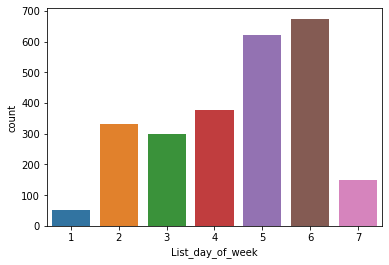

In [13]:
sb.countplot(data=sample_df, x='List_day_of_week');

In [15]:
from pyspark.sql.functions import datediff
df = df.withColumn('OFFMARKETDATE_new', func(col('OFFMARKETDATE')))
df = df.withColumn('DAYSONMARKET', datediff('OFFMARKETDATE_new', 'LISTDATE_new'))
df[['OFFMARKETDATE_new', 'LISTDATE_new', 'DAYSONMARKET']].show(5)

+-----------------+------------+------------+
|OFFMARKETDATE_new|LISTDATE_new|DAYSONMARKET|
+-----------------+------------+------------+
|       2017-07-30|  2017-07-15|          15|
|       2017-10-13|  2017-10-09|           4|
|       2017-07-24|  2017-06-26|          28|
|       2017-09-13|  2017-08-25|          19|
|       2017-10-03|  2017-09-12|          21|
+-----------------+------------+------------+
only showing top 5 rows



In [24]:
from pyspark.sql.functions import *
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1) \
                                        .when(has_detached_garage, 0) \
                                        .otherwise(None)))

df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(5)

+--------------------+-------------------+
|   GARAGEDESCRIPTION|has_attached_garage|
+--------------------+-------------------+
|     Attached Garage|                  1|
|Attached Garage, ...|                  1|
|     Attached Garage|                  1|
|Attached Garage, ...|                  1|
|Attached Garage, ...|                  1|
+--------------------+-------------------+
only showing top 5 rows



In [54]:
df = df.withColumn('roof_list', split(df['ROOF'], ', '))
df[['No', 'roof_list']].show(5)

+---+--------------------+
| No|           roof_list|
+---+--------------------+
|  1|                null|
|  2|[Asphalt Shingles...|
|  3|                null|
|  4|[Asphalt Shingles...|
|  5|[Asphalt Shingles...|
+---+--------------------+
only showing top 5 rows



In [55]:
roof_df = df.withColumn('ex_roof_list', explode(df['roof_list']))
roof_df[['No', 'ex_roof_list']].show()

+---+-------------------+
| No|       ex_roof_list|
+---+-------------------+
|  2|   Asphalt Shingles|
|  2|            Pitched|
|  2|Age 8 Years or Less|
|  4|   Asphalt Shingles|
|  4|            Pitched|
|  4|Age 8 Years or Less|
|  5|   Asphalt Shingles|
|  5|   Age Over 8 Years|
|  6|   Asphalt Shingles|
|  6|Age 8 Years or Less|
|  7|   Asphalt Shingles|
|  7|Age 8 Years or Less|
|  8|   Asphalt Shingles|
|  9|   Asphalt Shingles|
| 10|   Asphalt Shingles|
| 11|   Asphalt Shingles|
| 12|   Asphalt Shingles|
| 13|   Asphalt Shingles|
| 14|   Asphalt Shingles|
| 14|Age 8 Years or Less|
+---+-------------------+
only showing top 20 rows



In [56]:
roof_df = roof_df.withColumn('constant_val', lit(1))
roof_df[['No', 'ex_roof_list', 'constant_val']].show(5)

+---+-------------------+------------+
| No|       ex_roof_list|constant_val|
+---+-------------------+------------+
|  2|   Asphalt Shingles|           1|
|  2|            Pitched|           1|
|  2|Age 8 Years or Less|           1|
|  4|   Asphalt Shingles|           1|
|  4|            Pitched|           1|
+---+-------------------+------------+
only showing top 5 rows



In [57]:
roof_piv_df = roof_df.groupBy('No').pivot('ex_roof_list') \
                    .agg(coalesce(first('constant_val')))
# roof_piv_df = roof_piv_df.fillna(0)
roof_piv_df.orderBy('No').show(5)

+---+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
| No|Age 8 Years or Less|Age Over 8 Years|Asphalt Shingles|Flat|Metal|Other|Pitched|Rubber|Shakes|Slate|Tar/Gravel|Tile|Unspecified Shingle|Wood Shingles|
+---+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|  2|                  1|            null|               1|null| null| null|      1|  null|  null| null|      null|null|               null|         null|
|  4|                  1|            null|               1|null| null| null|      1|  null|  null| null|      null|null|               null|         null|
|  5|               null|               1|               1|null| null| null|   null|  null|  null| null|      null|null|               null|         null|
|  6|                  1|            null|               1|null| null|

In [58]:
joined_data = df.join(roof_piv_df, on='No', how='left')
col_fill_na = roof_piv_df.columns
joined_data = joined_data.fillna(0, subset=col_fill_na)
joined_data.show(5)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+----------+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+

Binarizer

In [68]:
# Phai cast qua double vi Binarizer khong xu ly duoc Integer
df = df.withColumn('FIREPLACES', df['FIREPLACES'].cast('double'))
bin = Binarizer(threshold=0, inputCol='FIREPLACES', outputCol='FireplaceB')
df_new = bin.transform(df)
df_new[['FIREPLACES', 'FireplaceB']].show(10)

+----------+----------+
|FIREPLACES|FireplaceB|
+----------+----------+
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       1.0|       1.0|
|       1.0|       1.0|
|       1.0|       1.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
|       0.0|       0.0|
+----------+----------+
only showing top 10 rows



Bucketizer

In [67]:
splits = [0, 1, 2, 3, 4, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BATHSTOTAL', outputCol='baths')
df_new = buck.transform(df)
df_new[['BATHSTOTAL', 'baths']].where(df['BATHSTOTAL'] > 3).show(10)

+----------+-----+
|BATHSTOTAL|baths|
+----------+-----+
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         4|  4.0|
|         5|  4.0|
|         5|  4.0|
+----------+-----+
only showing top 10 rows



In [63]:
df[['BATHSTOTAL']].distinct().show()

+----------+
|BATHSTOTAL|
+----------+
|         1|
|         6|
|         3|
|         5|
|         4|
|         7|
|         2|
+----------+



One hot encoding

In [70]:
df1 = spark.createDataFrame([
    ("a", 2.0),
    ("b", 2.0),
    ("c", 1.0),
    ("a", 1.0),
    ("a", 0.0),
    ("b", 1.0),
    ("c", 1.0)
], ["categoryIndex", "categoryIndex2"])
stringID = StringIndexer(inputCol="categoryIndex", outputCol="categoryIndex1") 
indexer = stringID.fit(df1)
df1 = indexer.transform(df1)
df1.show(5)

+-------------+--------------+--------------+
|categoryIndex|categoryIndex2|categoryIndex1|
+-------------+--------------+--------------+
|            a|           2.0|           0.0|
|            b|           2.0|           1.0|
|            c|           1.0|           2.0|
|            a|           1.0|           0.0|
|            a|           0.0|           0.0|
+-------------+--------------+--------------+
only showing top 5 rows



In [72]:
encoder = OneHotEncoder(inputCol="categoryIndex1",
                        outputCol="categoryVec1", 
                        dropLast=False) # default
encoded = encoder.transform(df1)
encoded["categoryIndex", "categoryIndex1", "categoryVec1"].show()

+-------------+--------------+-------------+
|categoryIndex|categoryIndex1| categoryVec1|
+-------------+--------------+-------------+
|            a|           0.0|(3,[0],[1.0])|
|            b|           1.0|(3,[1],[1.0])|
|            c|           2.0|(3,[2],[1.0])|
|            a|           0.0|(3,[0],[1.0])|
|            a|           0.0|(3,[0],[1.0])|
|            b|           1.0|(3,[1],[1.0])|
|            c|           2.0|(3,[2],[1.0])|
+-------------+--------------+-------------+



In [75]:
encoder = OneHotEncoder(inputCol="categoryIndex1",
                        outputCol="categoryVec1", 
                        dropLast=True) # default
encoded = encoder.transform(df1)
encoded["categoryIndex", "categoryIndex1", "categoryVec1"].show()

+-------------+--------------+-------------+
|categoryIndex|categoryIndex1| categoryVec1|
+-------------+--------------+-------------+
|            a|           0.0|(2,[0],[1.0])|
|            b|           1.0|(2,[1],[1.0])|
|            c|           2.0|    (2,[],[])|
|            a|           0.0|(2,[0],[1.0])|
|            a|           0.0|(2,[0],[1.0])|
|            b|           1.0|(2,[1],[1.0])|
|            c|           2.0|    (2,[],[])|
+-------------+--------------+-------------+



In [79]:
string_indexer = StringIndexer(inputCol='City', outputCol='City_Index')
model = string_indexer.fit(df)
indexed = model.transform(df)
indexed[['City', 'City_Index']].show(5)

+----------------+----------+
|            City|City_Index|
+----------------+----------+
|LELM - Lake Elmo|       4.0|
|LELM - Lake Elmo|       4.0|
|LELM - Lake Elmo|       4.0|
|LELM - Lake Elmo|       4.0|
|LELM - Lake Elmo|       4.0|
+----------------+----------+
only showing top 5 rows



In [89]:
one_hot = OneHotEncoder(inputCol='City_Index', outputCol='City_encode', dropLast=True)
encoded = one_hot.transform(indexed)
encoded[['City_Index', 'City_encode']].show(5)

+----------+-----------+
|City_Index|City_encode|
+----------+-----------+
|       4.0|  (4,[],[])|
|       4.0|  (4,[],[])|
|       4.0|  (4,[],[])|
|       4.0|  (4,[],[])|
|       4.0|  (4,[],[])|
+----------+-----------+
only showing top 5 rows



In [91]:
print('Is df is cached? {}'.format(df.is_cached))
df.cache()
print('Is df is cached? {}'.format(df.is_cached))
df.unpersist()
print('Is df is cached? {}'.format(df.is_cached))

Is df is cached? False
Is df is cached? True
Is df is cached? False
